# Daq Setup

In [1]:
import sys
import os

import pynq

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from Biquad.Biquad_Daq import Biquad_Daq
from Biquad.SimBiquad import SimBiquad

from Utils.PlotTools import PlottingTools as pt

from Waveforms.Waveform import Waveform
from Waveforms.Gated import Gated
from Waveforms.Filterred import Filterred

daq = Biquad_Daq(None, None, 4, 2**10)

Turning on SYNC
Turning off SYNC


# Test FIR

## Test single zero FIR

In [2]:
def rms(arr):
    square_sum = sum(x ** 2 for x in arr)
    mean_square = square_sum / len(arr)
    return np.sqrt(mean_square)

In [3]:
def update_daq_zero(A, B):
    daq.setA(A)
    daq.setB(B)
    
    daq.set_single_zero_fir()
    
def update_sim_zero(A, B, biquad):
    biquad.setA(A)
    biquad.setB(B)
    
    biquad.single_zero_fir()
    return biquad

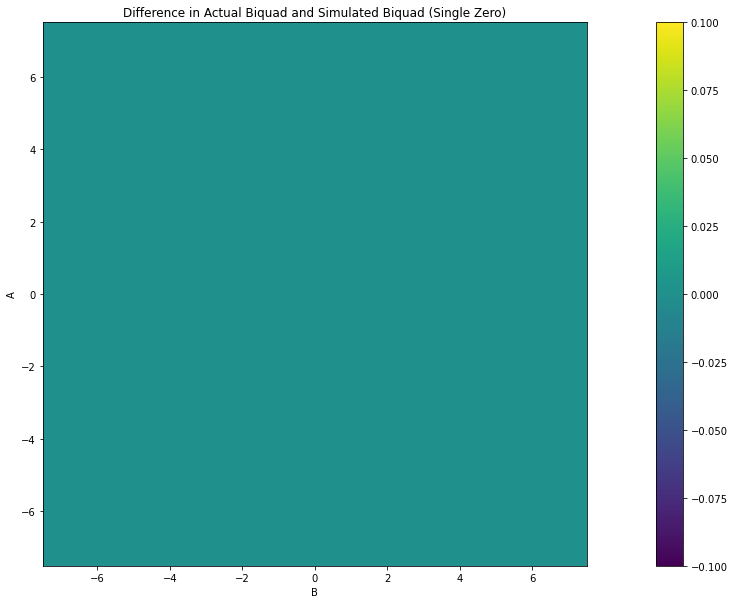

In [4]:
result = []
temp = []
for A in range(-8, 8):
    for B in range(-8,8):
        
        update_daq_zero(A=A, B=B)
    
        daq.JupyterAcquire()

        biquad = SimBiquad(data=daq.waveforms[0].waveform, A=A, B=B, P=0, theta=1, M=8)  
        biquad.IIR()
        temp.append(rms(np.array(daq.waveforms[2].waveform[:512])-biquad.get_decimated()))
    result.append(temp)
    temp = []

plt.figure(figsize=(25, 10))
plt.imshow(result, cmap='viridis', interpolation='nearest', extent=[-7.5,7.5,7.5,-7.5])
plt.colorbar()  # Show a colorbar
plt.title("Difference in Actual Biquad and Simulated Biquad (Single Zero)")
plt.xlabel('B')
plt.ylabel('A')
plt.gca().invert_yaxis()
plt.show()

# if np.mean(result.flatten()) == 0:
#     print("All good innit")
# else:
#     print("Somethings wrong")

## Test f and g

In [5]:
def update_daq_fir1(A, B, P, Theta, M):
    daq.setA(A)
    daq.setB(B)
    daq.setP(P)
    daq.setTheta(np.pi*Theta)
    daq.setM(M)
    
    daq.set_single_zero_fir()
    daq.set_f_fir(0)
    daq.set_g_fir(0)
    
def update_sim_fir1(A, B, P, Theta, M, biquad):
    biquad.setA(A)
    biquad.setB(B)
    biquad.setP(P)
    biquad.setTheta(np.pi*Theta)
    
    biquad.single_zero_fir()
    biquad.first_constants()
    return biquad

### Test P

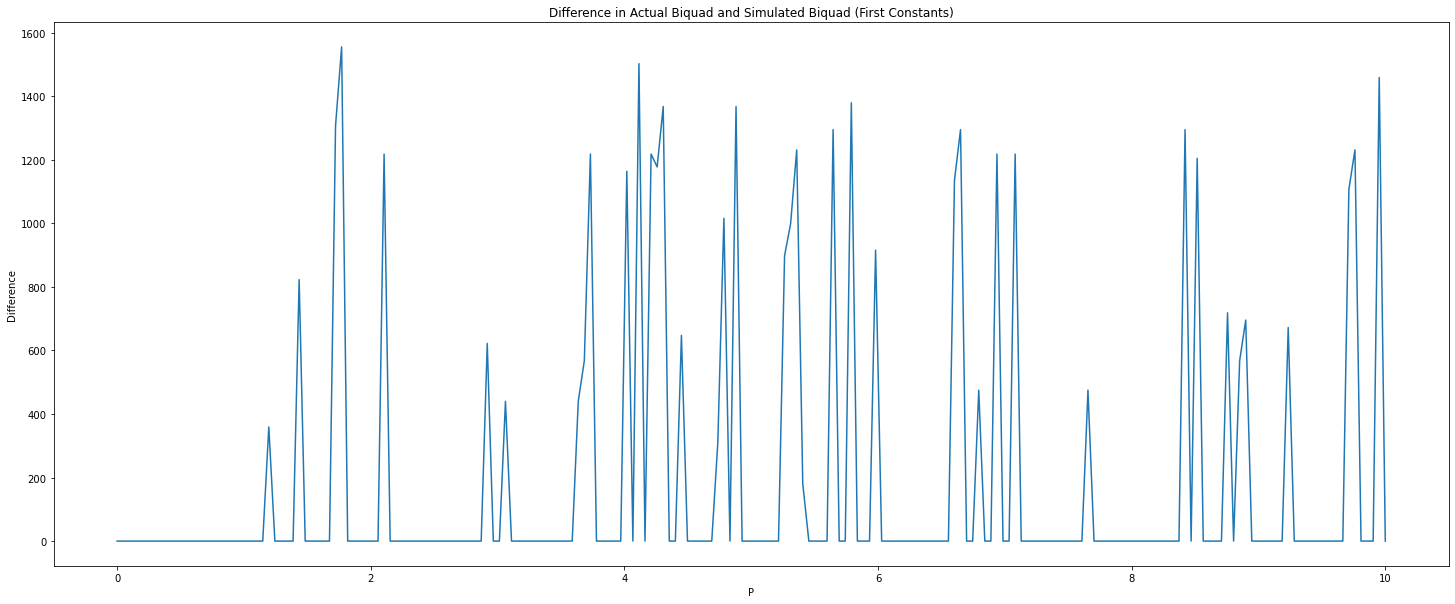

In [11]:
ps = np.linspace(0,10,210)
# print(ps)
result = []

A = 1
B = 1
theta = 1

for P in ps:
    daq.setA(A)
    daq.setB(B)
    daq.setP(P)
    daq.setTheta(np.pi*theta)
    
    daq.set_single_zero_fir()
    daq.set_f_fir(0)
    daq.set_g_fir(0)
    
    daq.JupyterAcquire()

    biquad = SimBiquad(data=daq.adcBuffer[0] >> 4, A=A, B=B, P=P, theta=np.pi*theta)  
    biquad.set_daq_coeffs(daq.get_coeffs())
    biquad.single_zero_fir()
    biquad.first_constants()
    
    sim_output = Filterred(biquad.get_decimated1(), 280, 800)
    
    result.append(rms(np.array(daq.waveforms[2].waveform)-biquad.get_decimated1()[280:800]))

plt.figure(figsize=(25, 10))
plt.plot(ps, result)
plt.title("Difference in Actual Biquad and Simulated Biquad (First Constants)")
plt.xlabel('P')
plt.ylabel('Difference')
plt.show()


### Test Theta

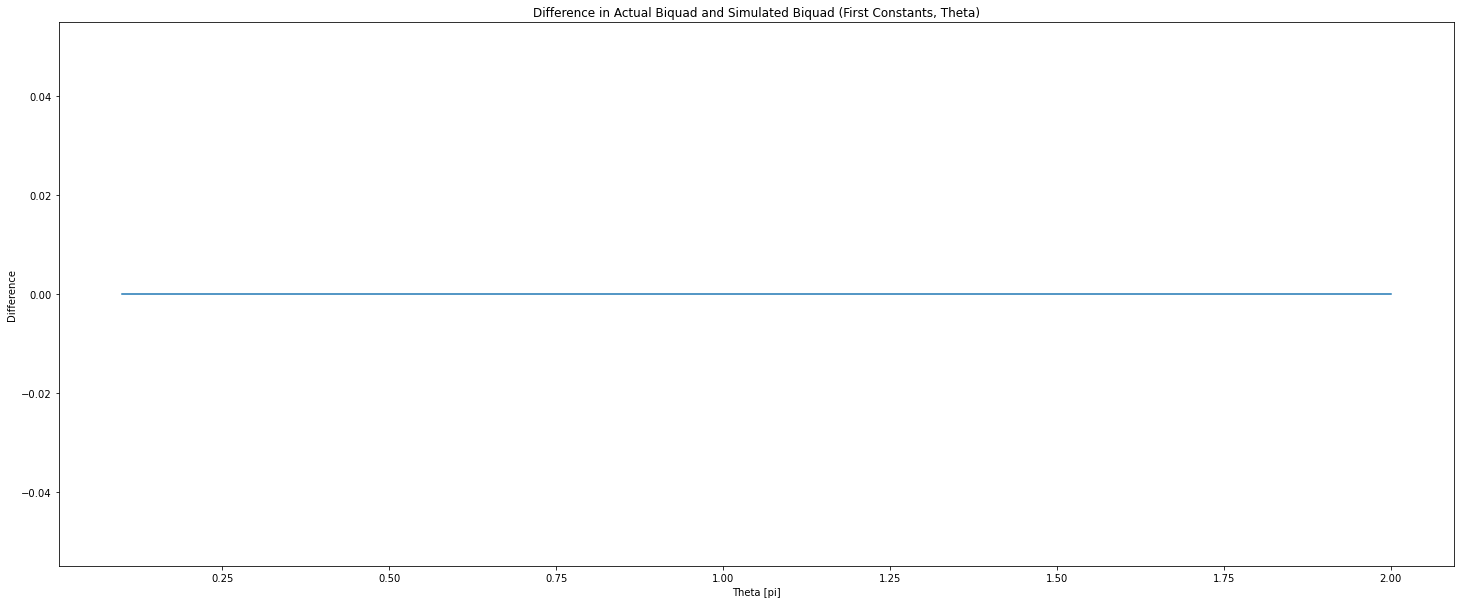

In [12]:
os = np.linspace(0.1,2,40)
result = []

A = 1
B = 1
P = 1


for theta in os:
    daq.setA(A)
    daq.setB(B)
    daq.setP(P)
    daq.setTheta(np.pi*theta)
    
    daq.set_single_zero_fir()
    daq.set_f_fir(0)
    daq.set_g_fir(0)
    
    daq.JupyterAcquire()

    biquad = SimBiquad(data=daq.adcBuffer[0] >> 4, A=A, B=B, P=P, theta=np.pi*theta)  
    biquad.set_daq_coeffs(daq.get_coeffs())
    biquad.single_zero_fir()
    biquad.first_constants()
    
    sim_output = Filterred(biquad.get_decimated1(), 280, 800)
    
    result.append(rms(np.array(daq.waveforms[2].waveform)-biquad.get_decimated1()[280:800]))
    
plt.figure(figsize=(25, 10))
plt.plot(os, result)
plt.title("Difference in Actual Biquad and Simulated Biquad (First Constants, Theta)")
plt.xlabel('Theta [pi]')
plt.ylabel('Difference')
plt.show()

### Test Both

In [ ]:
print(np.linspace(0,1,21))
print(np.linspace(0.1,2,20))

(210, 40)


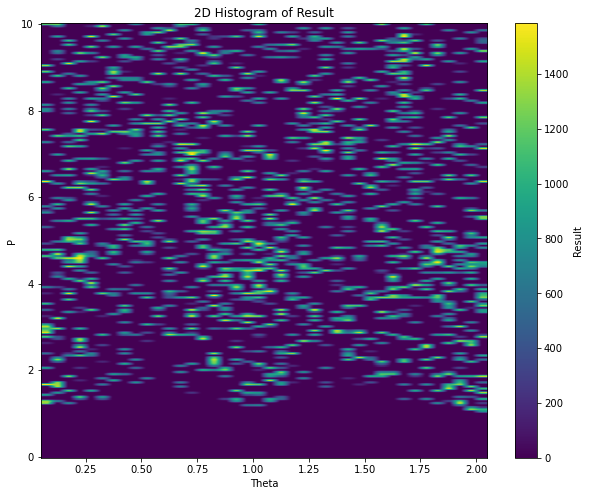

In [14]:
# ps = np.linspace(0,1,21)
# os = np.linspace(0.1,2,20)

ps = np.linspace(0,10,210)
os = np.linspace(0.1,2,20)

A = 1
B = 1

result = []

for P in ps:
    temp = []
    for theta in os:
        
        
        daq.setA(A)
        daq.setB(B)
        daq.setP(P)
        daq.setTheta(np.pi*theta)

        daq.set_single_zero_fir()
        daq.set_f_fir(0)
        daq.set_g_fir(0)

        daq.JupyterAcquire()

        biquad = SimBiquad(data=daq.adcBuffer[0] >> 4, A=A, B=B, P=P, theta=np.pi*theta)  
        biquad.set_daq_coeffs(daq.get_coeffs())
        biquad.single_zero_fir()
        biquad.first_constants()

        sim_output = Filterred(biquad.get_decimated1(), 280, 800)

        temp.append(rms(np.array(daq.waveforms[2].waveform)-biquad.get_decimated1()[280:800]))

    result.append(temp)
    
result = np.array(result)
print(np.shape(result))


plt.figure(figsize=(10, 8))
plt.imshow(result, extent=[os.min()-0.05, os.max()+0.05, ps.min()-0.025, ps.max()+0.025], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Result')
plt.xlabel('Theta')
plt.ylabel('P')
plt.title('2D Histogram of Result')
plt.show()

# plt.figure(figsize=(25, 10))
# plt.imshow(result, cmap='viridis', interpolation='nearest', extent=[0, 1, 0.1, 2])
# plt.colorbar()  # Show a colorbar
# plt.title("Difference in Actual Biquad and Simulated Biquad (First Constants, both)")
# plt.xlabel('P')
# plt.ylabel('Theta')
# plt.gca().invert_yaxis()
# plt.show()